# Predicting Algerian Forest Fires

# Models

We build a random forest model and a logistic regression model to predict the occurence forest fires. We then compare the results.

In [92]:
import os
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

## GLOBAL VARIABLES

# GRIDSEARCH default = False. Change to True to run GridSearchCV again.
GRIDSEARCH = False

In [93]:
# Load and further clean data
data = pd.read_csv("data/Algerian_forest_fires_dataset_CLEANED.csv")

# Random Forest Model

## Intro

Given the size of the dataset ($243 \times 15$), building a random forest would probably be an overkill. Nontheless, we are just curious how the performance would differ when compared to the Logistic Regression model.

Because random forest is based on bootstrap aggregating decision trees, we don't need to check any statistical features on our data since we are not making any mathematical assumptions. The only thing that need to be done further on the data is to encode all the categorical variables. The Random Forest Classifier in sklearn cannot recognize string typed categorical variables in default, thus we need to encode them into ${0,1}$ integers.

## Process Data

Given that our dataset is small, we decided to reserve $1/3$ of the data as testing. We don't want to reserve too much, otherwise random forest might perform badly on a very small traning dataset. This is because bootstrap sampling on small datasets might result in many repeated samples.

In [76]:
def preprocess_data(data, features_to_drop=[]):
    
    y = data['Classes'].values
    X = data.drop(["Unnamed: 0"], axis=1)
    X = X.drop(features_to_drop, axis=1)
    
    # One hot encode categorial variables
    X['Region'].loc[X['Region'] == 'Bejaia'] = 0
    X['Region'].loc[X['Region'] == 'Sidi-Bel Abbes'] = 1
    
    y[y == "notfire"] = 0
    y[y == "fire"] = 1
    y = y.astype(int)
    
    return X, y

In [77]:
X, y = preprocess_data(data)
# Train test split on 1/3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [78]:
X_train.head()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
226,14,9,2012,28,81,15,0.0,84.6,12.6,41.5,4.3,14.3,5.7,1,1
65,5,8,2012,34,65,13,0.0,86.8,11.1,29.7,5.2,11.5,6.1,1,0
168,18,7,2012,33,68,15,0.0,86.1,23.9,51.6,5.2,23.9,9.1,1,1
206,25,8,2012,34,40,18,0.0,92.1,56.3,157.5,14.3,59.5,31.1,1,1
144,23,6,2012,33,59,16,0.8,74.2,7.0,8.3,1.6,6.7,0.8,0,1


## Hyperparameter Tuning

Perform Grid Search Cross Validation on the random forest model. The algorithm search through different values for hyperparameters and perform cross validation on each combination. Given the small dataset, I decided to search through the number of trees between the range $[1,100]$ and the maximum depth between $[1,5]$. The algorithm will perform $10$-Fold corss validation on each combination of hyperparameters.

In [69]:
## Grid search cross validation
if GRIDSEARCH :
    # Define param_grid
    param_grid = {"n_estimators" : (10**np.linspace(0, 2, 40)).astype(int),
              "max_depth" : [1,2,3,4,5]}
    # Define random forest model
    rf_model = RandomForestClassifier(random_state=42)
    # Grid search cross validation
    grid = GridSearchCV(rf_model, param_grid, scoring="recall", cv=10)
    grid.fit(X_train, y_train)
    
    # Print best result
    print(grid.best_params_, grid.best_score_)
    
    # Save grid search model
    joblib.dump(grid, 'models/random_forest_gridcv.pkl')
else :
    if os.path.exists("models/random_forest_gridcv.pkl") :
        grid = joblib.load("models/random_forest_gridcv.pkl")
        print("Successfully loaded pre-trained model.")
    else :
        print("The pre-trained model does not exist. Please change GRIDSEARCH to true.")

Successfully loaded pre-trained model.


### Selecting the Metric for Evaluation

I chose to evaluate on the **recall** (or **true positive rate**) for each model during cross validation. This is because, as a model predicting forest fires, we really don't want to predict no fire when there is actually fire. Therefore, we want to penalize **false negatives** (predicting no fire wrongly). Recall does exactly this job.

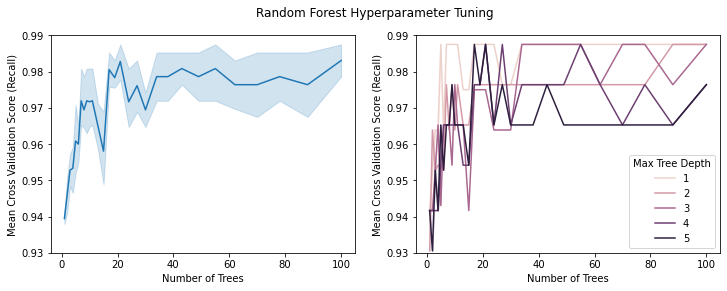

In [70]:
# Plot CV results
cv_results = pd.DataFrame(grid.cv_results_)

fig, axs = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot("param_n_estimators", "mean_test_score", data=cv_results, ax = axs[0])
sns.lineplot("param_n_estimators", "mean_test_score", data=cv_results, hue = "param_max_depth", ax = axs[1])
plt.suptitle("Random Forest Hyperparameter Tuning")
for ax in axs:
    ax.set(xlabel="Number of Trees", ylabel="Mean Cross Validation Score (Recall)", ylim=(0.93, 0.99))
axs[1].legend(title="Max Tree Depth")

plt.savefig("figures/random_forest.png")

### Interpretating the Result

The figures above display the results of cross validation. Observing the left figure we see that the cross validated recall (true positive rate) stablizes when there are more than $35$ trees being grown. On the right figure, we see that the tree with maximum depth of one is actually the best performing model overall. We can observe that when the number of trees is larger than $35$, the tree with depth one is consistently performing the best. Thus, based on the cross validation result, the best performing model have $38$ trees with maximum depth of $1$.

In [71]:
# Save best random forest
final_model = RandomForestClassifier(n_estimators=38, max_depth=1, random_state=42)
final_model.fit(X_train, y_train)
joblib.dump(final_model, 'models/random_forest.pkl')

['models/random_forest.pkl']

In [72]:
# Features never used:
X.columns[final_model.feature_importances_ == 0]

Index(['month', 'year', 'Ws', 'Region'], dtype='object')

In [73]:
# Most important feature
X.columns[np.argmax(final_model.feature_importances_)]

'Classes'

## Further Exploration

By looking into our final random forest model, we see that 'day', 'month', 'year', 'RH', 'Ws', and 'Region' are never being used as a condition to perform a split. We can also see that the most important feature that the random forest based on is tne 'ISI' (Initial Spread Index). 

# Logistic Regression

## Data Preprocessing

We first examine the correlation matrix of the weather metrics in our dataset. We find that DMC, DC, and BUI and highly correlated with one another. To avoid multicollinearity, we remove DC and BUI from our feature set. We choose to use DMC becuase it is the least correlated with the remaining features.

In [34]:
# Examine correlation matrix
data.iloc[:, 3:-2].corr()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
Temperature,1.000000,-0.651400,-0.284510,-0.326492,0.676568,0.485687,0.376284,0.603871,0.459789,0.566670
RH,-0.651400,1.000000,0.244048,0.222356,-0.644873,-0.408519,-0.226941,-0.686667,-0.353841,-0.580957
Ws,-0.284510,0.244048,1.000000,0.171506,-0.166548,-0.000721,0.079135,0.008532,0.031438,0.032368
Rain,-0.326492,0.222356,0.171506,1.000000,-0.543906,-0.288773,-0.298023,-0.347484,-0.299852,-0.324422
FFMC,0.676568,-0.644873,-0.166548,-0.543906,1.000000,0.603608,0.507397,0.740007,0.592011,0.691132
DMC,0.485687,-0.408519,-0.000721,-0.288773,0.603608,1.000000,0.875925,0.680454,0.982248,0.875864
DC,0.376284,-0.226941,0.079135,-0.298023,0.507397,0.875925,1.000000,0.508643,0.941988,0.739521
ISI,0.603871,-0.686667,0.008532,-0.347484,0.740007,0.680454,0.508643,1.000000,0.644093,0.922895
BUI,0.459789,-0.353841,0.031438,-0.299852,0.592011,0.982248,0.941988,0.644093,1.000000,0.857973
FWI,0.566670,-0.580957,0.032368,-0.324422,0.691132,0.875864,0.739521,0.922895,0.857973,1.000000


We preprocess the data by removing the 'year' column because there is only one value for the entire dataset. We also remove the DC and BUI columns. We encode 'Regions' in the feature matrix and 'Classes' in the y vector to binary representations. Lastly, we normalize the weather metrics in the feature matrix. 

In [82]:
def normalize(data, norm_features):
    for feat in norm_features:
        data[feat] = (data[feat] - data[feat].mean())/data[feat].std()

In [83]:
X, y = preprocess_data(data, ['Classes', 'year', 'DC', 'BUI'])
normalize(X, ['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'ISI', 'FWI'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Modeling

In [84]:
clf = LogisticRegression(penalty='l2',random_state=42).fit(X_train, y_train)

### Predictions and Metrics

We use our trained model to predict on the test set and display the confusion matrix.

In [85]:
predictions = clf.predict(X_test)
confusion = confusion_matrix(predictions, y_test)

# Calculate true negatives, false positives, false negatives, and true positives
tn, fp, fn, tp = confusion_matrix(predictions, y_test).ravel()
n = len(y_test)

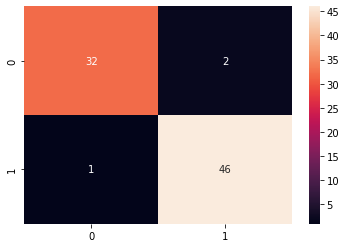

In [86]:
sns.heatmap(confusion, annot=True);
plt.savefig('figures/confusion_matrix.png')

We calculate accuracy, precision, and recall for out model. It looks like our model does well!

In [87]:
print('Accuracy: ' + str((tp+tn)/n))
print('Precision: ' + str(tp/(tp+fp)))
print('Recall: ' + str(tp/(tp+fn)))

Accuracy: 0.9629629629629629
Precision: 0.9583333333333334
Recall: 0.9787234042553191


To better evaluate our model, we examine the ROC curve. The area under the curve is close to 1, which is desired. 

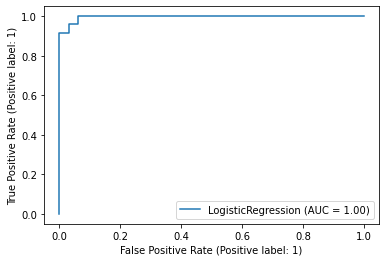

In [88]:
# Show roc curve 

plot_roc_curve(clf, X_test, y_test);
plt.savefig('figures/logistic_regression_roc.png')

### Interpreting the Result

A simple logistic regression model achieves astounding accuracy on the test set. It is possible that the data is inherently well-conditioned and that Algerian forest fires have particularly distinct features that set them apart from regular weather conditions. It is unclear how the model will respond to forest fires in other locations. Further exploration can be done by applying our model to areas with similar climates and monitoring the model's variance. A question to ponder is: Are Algerian forest fires easier to predict than other forest fires?

# Model Comparison